In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymf
from tqdm import tqdm

To simulate infinite systems, we provide the corresponding tight-binding model.

We exemplify this construction by computing the ground state of an infinite spinful chain with onsite interactions.

Because the ground state is an antiferromagnet, so we must build a two-atom cell. We name the two sublattices, $A$ and $B$. The Hamiltonian in is:
$$
H_0 = \sum_i c_{i, B}^{\dagger}c_{i, A} + c_{i, A}^{\dagger}c_{i+1, B} + h.c.
$$
We write down the spinful by simply taking $H_0(k) \otimes \mathbb{1}$.

In [2]:
hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
h_0 = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}

To build the tight-binding model, we need to generate a Hamiltonian on a k-point and the corresponding hopping vectors to generate a guess. We then verify the spectrum and see that the bands indeed consistent of two bands due to the Brillouin zone folding.

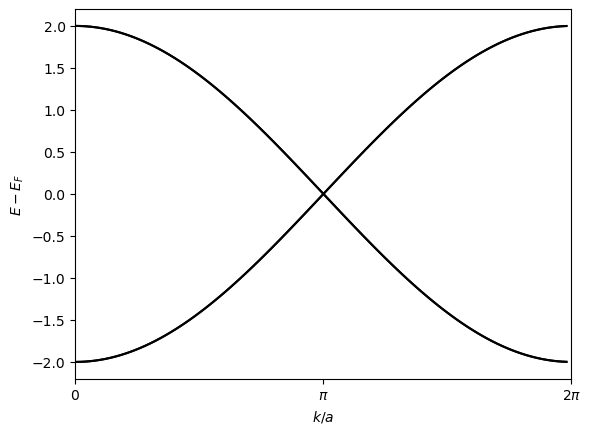

In [4]:
# Set number of k-points
nk = 100
ks = np.linspace(0, 2*np.pi, nk, endpoint=False) 
hamiltonians_0 = pymf.tb_to_khamvector(h_0, nk, ks=ks) 

# Perform diagonalization
vals, vecs = np.linalg.eigh(hamiltonians_0)
# Plot data
plt.plot(ks, vals, c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

Here, in the workflow to find the ground state, we use a helper function to build the initial guess. because we don't need a dense k-point grid in the self-consistent loop, we compute the spectrum later on a denser k-point grid.

Finally, we compute the eigen0alues for a set of Ualues of $U$. For this case, since the interaction is onsite only, the interaction matrix is simply
$$
H_{int} =
\left(\begin{array}{cccc}
    U & U & 0 & 0\\
    U & U & 0 & 0\\
    0 & 0 & U & U\\
    0 & 0 & U & U
\end{array}\right)~.
$$

In [5]:
def compute_sol(U, h_0, nk, filling=2):
    h_int = {
        (0,): U * np.kron(np.eye(2), np.ones((2, 2))),
    }
    guess = pymf.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
    full_model = pymf.Model(h_0, h_int, filling)
    mf_sol = pymf.solver(full_model, guess, nk=nk, optimizer_kwargs={"M":0})
    return pymf.add_tb(h_0, mf_sol)


def compute_gap_and_vals(full_sol, nk_dense, fermi_energy=0):
    h_kgrid = pymf.tb_to_khamvector(full_sol, nk_dense)
    vals = np.linalg.eigvalsh(h_kgrid)

    emax = np.max(vals[vals <= fermi_energy])
    emin = np.min(vals[vals > fermi_energy])
    return np.abs(emin - emax), vals


def compute_phase_diagram(
    Us,
    nk,
    nk_dense,
):
    gaps = []
    vals = []
    for U in tqdm(Us):
        full_sol = compute_sol(U, h_0, nk)
        gap, _vals = compute_gap_and_vals(full_sol, nk_dense)
        gaps.append(gap)
        vals.append(_vals)

    return np.asarray(gaps, dtype=float), np.asarray(vals)

In [13]:
# Interaction strengths
Us = np.linspace(0.5, 10, 20, endpoint=True)
nk, nk_dense = 40, 100
gap, vals = compute_phase_diagram(Us=Us, nk=nk, nk_dense=nk_dense)

 75%|███████▌  | 15/20 [00:02<00:00,  5.07it/s]/Users/rzijderveld/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=9.07651e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/rzijderveld/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=8.54968e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/rzijderveld/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=8.17567e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/rzijderveld/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=8.88621e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/rzijderveld/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-c

NoConvergence: [ 1.86715628e+00  4.47287535e-02 -1.23356829e-04  1.20430729e-03
  4.47287535e-02  2.63543104e+00  2.63234161e-03  3.71702031e-03
 -1.23356829e-04  2.63234161e-03  1.86002862e+00  4.51677226e-02
  1.20430729e-03  3.71702031e-03  4.51677226e-02  2.64245378e+00
  0.00000000e+00  1.61192759e-01 -1.51104882e-03  1.47113079e-03
 -1.61192759e-01  0.00000000e+00  5.03808388e-03  1.99828384e-03
  1.51104882e-03 -5.03808388e-03  0.00000000e+00  1.64032886e-01
 -1.47113079e-03 -1.99828384e-03 -1.64032886e-01  0.00000000e+00]

In [9]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(vals=(["Us", "ks", "n"], vals), gap=(["Us"], gap)),
    coords=dict(
        Us=Us,
        ks=np.linspace(0, 2 * np.pi, nk_dense),
        n=np.arange(vals.shape[-1])
    ),
)


We observe that as the interaction strength increases, a gap opens due to the antiferromagnetic ordering.

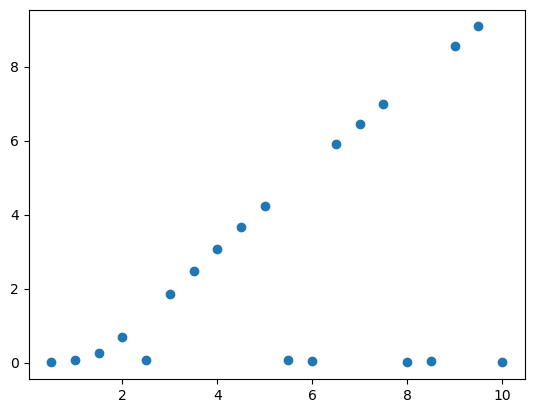

In [11]:
plt.scatter(Us, gap)

In [10]:
ds.vals.plot.scatter(x="ks", hue="Us", ec=None, s=5)
plt.axhline(0, ls="--", c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

AttributeError: '_PlotMethods' object has no attribute 'scatter'

The Hartree-Fock dispersion should follow (see [these notes](https://www.cond-mat.de/events/correl11/manuscript/Lechermann.pdf))
$$
\epsilon_{HF}^{\sigma}(\mathbf{k}) = \epsilon(\mathbf{k}) + U \left(\frac{n}{2} + \sigma m\right)
$$
where $m=(\langle n_{i\uparrow} \rangle - \langle n_{i\downarrow} \rangle) / 2$ is the magnetization per atom and $n = \sum_i \langle n_i \rangle$ is the total number of atoms per cell. Thus, for the antiferromagnetic groundstate, $m=1/2$ and $n=2$. The gap thus should be $\Delta=U$. And we can confirm it indeed follows the expected trend.

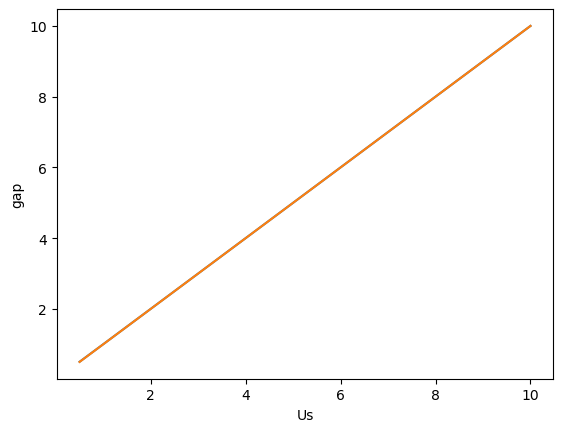

In [24]:
ds.gap.plot()
plt.plot(ds.Us, ds.Us)
plt.show()

We can also fit 

In [25]:
ds.gap.polyfit(dim="Us", deg=1).polyfit_coefficients[0].data

array(0.9997852)

In [20]:
ds.to_netcdf("./data/1d_hubbard_example.nc")

In [ ]:

```{code-cell} ipython3
def compute_phase_diagram(
    Us,
    nk,
    nk_dense,
    filling=2,
):
    gap = []
    vals = []
    for U in tqdm(Us):
        # onsite interactions
        guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
        full_model = Model(h_0, h_int, filling)
        mf_sol = solver(full_model, guess, nk=nk)
        hkfunc = transforms.tb_to_kfunc(add_tb(h_0, mf_sol))
        ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
        hkarray = np.array([hkfunc(kx) for kx in ks_dense])
        _vals = np.linalg.eigvalsh(hkarray)
        _gap = (utils.compute_gap(add_tb(h_0, mf_sol), fermi_energy=0, nk=nk_dense))
        gap.append(_gap)
        vals.append(_vals)
    return np.asarray(gap, dtype=float), np.asarray(vals)

import xarray as xr

ds = xr.Dataset(
    data_vars=dict(vals=(["Us", "ks", "n"], vals), gap=(["Us"], gap)),
    coords=dict(
        Us=Us,
        ks=np.linspace(0, 2 * np.pi, nk_dense),
        n=np.arange(vals.shape[-1])
    ),
)

# Interaction strengths
Us = np.linspace(0.5, 10, 20, endpoint=True)
nk, nk_dense = 40, 100
gap, vals = compute_phase_diagram(Us=Us, nk=nk, nk_dense=nk_dense)

ds.vals.plot.scatter(x="ks", hue="Us", ec=None, s=5)
plt.axhline(0, ls="--", c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

```

The Hartree-Fock dispersion should follow (see [these notes](https://www.cond-mat.de/events/correl11/manuscript/Lechermann.pdf))
$$
\epsilon_{HF}^{\sigma}(\mathbf{k}) = \epsilon(\mathbf{k}) + U \left(\frac{n}{2} + \sigma m\right)
$$
where $m=(\langle n_{i\uparrow} \rangle - \langle n_{i\downarrow} \rangle) / 2$ is the magnetization per atom and $n = \sum_i \langle n_i \rangle$ is the total number of atoms per cell. Thus, for the antiferromagnetic groundstate, $m=1/2$ and $n=2$. The gap thus should be $\Delta=U$. And we can confirm it indeed follows the expected trend.
